## qflib Library Examples and HW 4 Solution

In [1]:
import qflib as qf
import numpy as np
import os
import matplotlib.pyplot as plt
print("qflib version: {0}".format(qf.version()))
print("pid: {0}".format(os.getpid()))

qflib version: 0.5.0-debug
pid: 10072


In [2]:
name = "World"
print(qf.sayHello(name))

Hello World!


In [3]:
x = [1, 2, 3]
y = [4, 5]
op = qf.outerProd(x, y)
print(f'x: {x}\ny: {y}')
print(f'outerProd:\n{op}')

x: [1, 2, 3]
y: [4, 5]
outerProd:
[[ 4.  5.]
 [ 8. 10.]
 [12. 15.]]


In [4]:
m = np.array([[1, 2, 3], [4, 5, 6]])
em = qf.echoMatrix(m)
print(f'orig matrix:\n{m}')
print(f'echo matrix:\n{em}')

orig matrix:
[[1 2 3]
 [4 5 6]]
echo matrix:
[[1. 2. 3.]
 [4. 5. 6.]]


### Analytic Prices

In [5]:
#fwdprice
fwdpx = qf.fwdPrice(spot = 100, timetoexp = 1.0, intrate = 0.02, divyield = 0.04)
print('Forward price analytic solution')
print(f'Price={fwdpx:.4f}')

Forward price analytic solution
Price=98.0199


In [6]:
#digibs
digi = qf.digiBS(payofftype = 1, spot = 100, timetoexp = 1.0, strike = 100,
                  intrate = 0.02, divyield = 0.04, volatility = 0.2)
print('Digital option using Black-Scholes analytic solution')
print(f'Price={digi:}')

Digital option using Black-Scholes analytic solution
Price=0.4124090746144899


In [7]:
euro = qf.euroBS(payofftype = 1, spot = 100, timetoexp = 1.0, strike = 100,
                  intrate = 0.02, divyield = 0.04, volatility = 0.4)
print('European option using Black-Scholes analytic solution')
print(f'Price={euro:}')

European option using Black-Scholes analytic solution
Price=14.432724162013134


## Homework 5 problem 1

In [ ]:
#checking my function with the first row of the data provided
greeks = qf.euroBS(1, 100.0, 100.0, 2.0, 0.04, 0.02, 0.30)
print("BS Price at t=0 is", greeks[0], " Delta=", greeks[1])

In [16]:
import pandas as pd

# Parameters
N = 10000   # Number of option units (short position)
K = 100     # Strike
T = 2.0     # Time to expiration (years)
r = 0.04    # Risk-free rate
q = 0.02   # Dividend yield
sigma = 0.30  # Volatility
payoff = 1  # 1 for call

# Quarterly times and given spot path
times = np.array([0.00, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00])
spot_prices = np.array([100.00, 105.00, 110.00, 92.00, 103.00, 90.00, 110.00, 95.00, 88.00])

# Create a DataFrame with placeholders
df = pd.DataFrame({
    'Time': times,
    'Spot': spot_prices,
    'Option_Price': np.nan,
    'Delta': np.nan,
    'Growth': np.nan,
    'Opt_Units': -N,   # We are short the options at all times
    'Stk_Units': np.nan,
    'Opt_Val': np.nan,
    'Stk_Val': np.nan,
    'Cash_Acc': np.nan,
    'Tot_Val': np.nan
})

In [19]:
# looping over each quarterly rebalancing date
for i in range(len(times)):
    # Time to maturity from this date
    tenor = T - times[i]
    
    # -- 1) Compute Black–Scholes price/delta (or intrinsic at expiration) --
    if tenor > 0:
        
        greeks = qf.euroBS(payoff, spot_prices[i], K, tenor, r, q, sigma)
        option_price = greeks[0]
        delta = greeks[1]
    else:
        # At final maturity (tenor <= 0), option payoff is intrinsic
        option_price = max(0, spot_prices[i] - K)
        delta = 1.0 if (spot_prices[i] > K) else 0.0
        
    
    df.loc[i, 'Option_Price'] = option_price
    df.loc[i, 'Delta'] = delta
    
    #Growth Factor
    if i == 0:
        df.loc[i, 'Growth'] = 1.0  # No previous period at t=0
    else:
        dt = times[i] - times[i - 1]
        df.loc[i, 'Growth'] = np.exp(r * dt)
    
    #Hedge ratio and Cash --
    if i == 0:
        
        # Hedge = -N * Delta shares
        stk_units_i = -df.loc[i, 'Opt_Units'] * df.loc[i, 'Delta']
        df.loc[i, 'Stk_Units'] = stk_units_i
        
        # Values
        opt_val_i = df.loc[i, 'Opt_Units'] * df.loc[i, 'Option_Price']
        stk_val_i = stk_units_i * df.loc[i, 'Spot']
        
        df.loc[i, 'Opt_Val'] = opt_val_i
        df.loc[i, 'Stk_Val'] = stk_val_i
        
        # Cash: we receive option premium (=-Opt_Val), pay for stock (-Stk_Val)
        df.loc[i, 'Cash_Acc'] = -(opt_val_i + stk_val_i)
        
    else:
        #For t>0, re-hedge and update cash
        
        # 1) Grow previous cash at risk-free rate
        previous_cash = df.loc[i-1, 'Cash_Acc']
        df.loc[i, 'Cash_Acc'] = previous_cash * df.loc[i, 'Growth']
        
        # 2) Rebalance the shares from old delta to new delta
        new_stk_units = -df.loc[i, 'Opt_Units'] * df.loc[i, 'Delta']
        old_stk_units = df.loc[i-1, 'Stk_Units']
        df.loc[i, 'Stk_Units'] = new_stk_units
        
        # 3) Cost from adjusting the hedge
        cost_of_rebalance = (new_stk_units - old_stk_units) * df.loc[i, 'Spot']
        
        # 4) Subtract that cost from the cash account
        df.loc[i, 'Cash_Acc'] -= cost_of_rebalance
        
        # 5) Update the value of the option and stock
        df.loc[i, 'Opt_Val'] = df.loc[i, 'Opt_Units'] * df.loc[i, 'Option_Price']
        df.loc[i, 'Stk_Val'] = new_stk_units * df.loc[i, 'Spot']
    
    # Compute total value
    df.loc[i, 'Tot_Val'] = df.loc[i, 'Opt_Val'] + df.loc[i, 'Stk_Val'] + df.loc[i, 'Cash_Acc']

# Final P&L 
final_pnl = df.loc[len(df) - 1, 'Tot_Val']

In [18]:
df.head(10)

,Time,Spot,Option_Price,Delta,Growth,Opt_Units,Stk_Units,Opt_Val,Stk_Val,Cash_Acc,Tot_Val
0,0.00,100.0,17.777303,0.596030,1.00000,-10000,5960.304084,-177773.031045,596030.408427,-418257.377382,0.000000
1,0.25,105.0,19.716559,0.636273,1.01005,-10000,6362.727734,-197165.585981,668086.412094,-464715.417155,6205.408958
2,0.50,110.0,21.762433,0.679434,1.01005,-10000,6794.341178,-217624.330729,747377.529594,-516863.363573,12889.835293
3,0.75,92.0,9.796680,0.485182,1.01005,-10000,4851.822012,-97966.802243,446367.625126,-343346.163474,5054.659408
4,1.00,103.0,14.346481,0.611344,1.01005,-10000,6113.436213,-143464.811956,629683.929890,-476743.112415,9476.005520
5,1.25,90.0,5.975691,0.407596,1.01005,-10000,4075.958380,-59756.909012,366836.254239,-298161.455463,8917.889765
6,1.50,110.0,15.232479,0.719351,1.01005,-10000,7193.507103,-152324.789430,791285.781342,-644088.387402,-5127.395490
7,1.75,95.0,3.818531,0.405606,1.01005,-10000,4056.061287,-38185.312688,385325.822303,-352504.230820,-5363.721205
8,2.00,88.0,0.000000,0.000000,1.01005,-10000,0.000000,-0.000000,0.000000,886.436053,886.436053


#### final P&L, i.e. (the total value Tot_Valt=2.00) = $886.44

In [8]:
# Problem 3: PPoly Curve Check

print("\nProblem 3: PPoly Curve Check")

# Define two piecewise polynomial curves of order 0
bkpoints1 = np.array([0.0, 1.0, 2.0, 3.0])
values1 = np.array([1.0, 2.0, 1.5, 0.5])

bkpoints2 = np.array([0.5, 1.5, 2.5, 3.5])
values2 = np.array([0.5, 1.0, 1.5, 2.0])

# Call qf.ppolySum function to add the curves
order = 0 
result = qf.ppolySum(bkpoints1, values1, bkpoints2, values2, order)

# Extract breakpoints and values from the result
result_bkpoints = result[:, 0]
result_values = result[:, 1]

print("Result of ppolySum:")
for i in range(len(result_bkpoints)):
    print(f"Breakpoint: {result_bkpoints[i]:.2f}, Value: {result_values[i]:.2f}")

# Create a sequence of x-values for evaluation (including breakpoints)
x_eval = np.linspace(0.0, 3.5, 100)

# Evaluate the original polynomials and their sum
# FIXED: ppolyEval takes 5 arguments: bkpoints, values, polyorder, xvec, derivorder
val1 = qf.ppolyEval(bkpoints1, values1, order, x_eval, 0)
val2 = qf.ppolyEval(bkpoints2, values2, order, x_eval, 0)
sum_val = qf.ppolyEval(result_bkpoints, result_values, order, x_eval, 0)

# Also compute direct sum for verification
direct_sum = val1 + val2


Problem 3: PPoly Curve Check
Result of ppolySum:
Breakpoint: 0.00, Value: 1.50
Breakpoint: 0.50, Value: 1.50
Breakpoint: 1.00, Value: 2.50
Breakpoint: 1.50, Value: 3.00
Breakpoint: 2.00, Value: 2.50
Breakpoint: 2.50, Value: 3.00
Breakpoint: 3.00, Value: 2.00
Breakpoint: 3.50, Value: 2.50


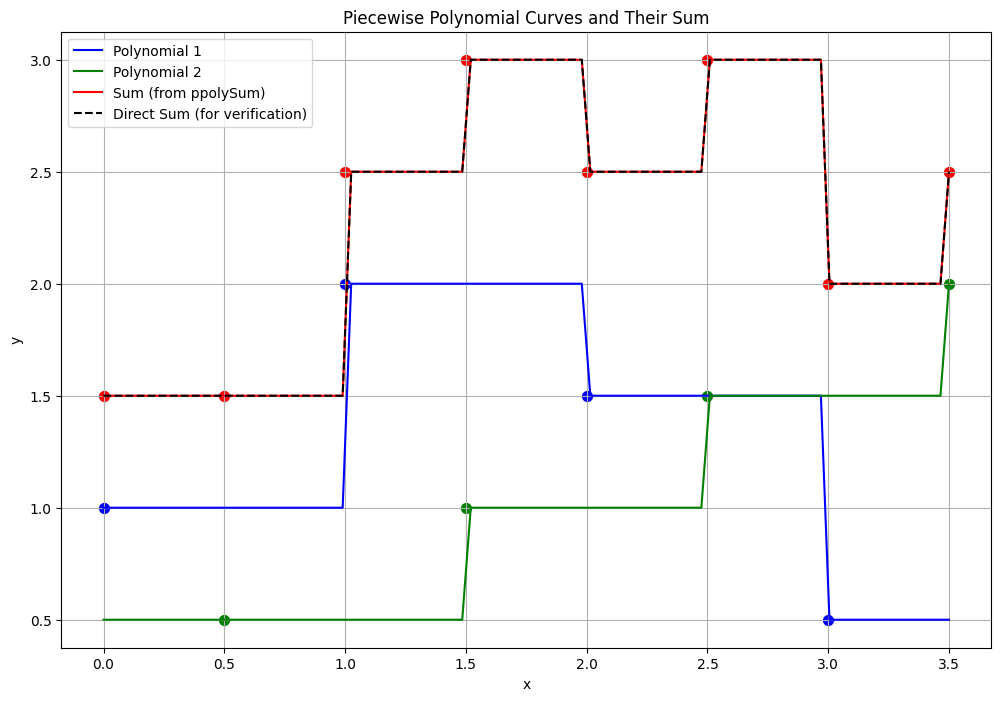

In [9]:
# Plot the original polynomials and their sum
plt.figure(figsize=(12, 8))
plt.plot(x_eval, val1, 'b-', label='Polynomial 1')
plt.plot(x_eval, val2, 'g-', label='Polynomial 2')
plt.plot(x_eval, sum_val, 'r-', label='Sum (from ppolySum)')
plt.plot(x_eval, direct_sum, 'k--', label='Direct Sum (for verification)')

# Add markers for breakpoints
plt.scatter(bkpoints1, values1, color='blue', s=50)
plt.scatter(bkpoints2, values2, color='green', s=50)
plt.scatter(result_bkpoints, result_values, color='red', s=50)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Piecewise Polynomial Curves and Their Sum')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# sum calculation by comparing direct sum vs. ppolySum
print("\nVerification of the sum:")
# Calculate maximum difference
max_diff = np.max(np.abs(sum_val - direct_sum))
print(f"Maximum difference between direct sum and ppolySum result: {max_diff:.10f}")

if max_diff < 1e-10:
    print("VALIDATION: The sum was correctly computed!")
else:
    print("WARNING: The sum may not be correctly computed!")
    
# Check by evaluating at specific breakpoints
print("\nEvaluating at all breakpoints:")
all_bkpoints = np.sort(np.unique(np.concatenate((bkpoints1, bkpoints2))))
for x in all_bkpoints:
    # Create a single-element array for evaluation
    x_array = np.array([x])
    val1_at_x = qf.ppolyEval(bkpoints1, values1, order, x_array, 0)[0]
    val2_at_x = qf.ppolyEval(bkpoints2, values2, order, x_array, 0)[0]
    sum_at_x = qf.ppolyEval(result_bkpoints, result_values, order, x_array, 0)[0]
    direct_at_x = val1_at_x + val2_at_x
    print(f"At x={x:.2f}: Poly1={val1_at_x:.2f}, Poly2={val2_at_x:.2f}, Sum={sum_at_x:.2f}, Direct={direct_at_x:.2f}, Diff={abs(sum_at_x-direct_at_x):.10f}")


Verification of the sum:
Maximum difference between direct sum and ppolySum result: 0.0000000000
VALIDATION: The sum was correctly computed!

Evaluating at all breakpoints:
At x=0.00: Poly1=1.00, Poly2=0.50, Sum=1.50, Direct=1.50, Diff=0.0000000000
At x=0.50: Poly1=1.00, Poly2=0.50, Sum=1.50, Direct=1.50, Diff=0.0000000000
At x=1.00: Poly1=2.00, Poly2=0.50, Sum=2.50, Direct=2.50, Diff=0.0000000000
At x=1.50: Poly1=2.00, Poly2=1.00, Sum=3.00, Direct=3.00, Diff=0.0000000000
At x=2.00: Poly1=1.50, Poly2=1.00, Sum=2.50, Direct=2.50, Diff=0.0000000000
At x=2.50: Poly1=1.50, Poly2=1.50, Sum=3.00, Direct=3.00, Diff=0.0000000000
At x=3.00: Poly1=0.50, Poly2=1.50, Sum=2.00, Direct=2.00, Diff=0.0000000000
At x=3.50: Poly1=0.50, Poly2=2.00, Sum=2.50, Direct=2.50, Diff=0.0000000000
